In [ ]:
# default_exp data.analyse_keywords

# Analyse keywords in product descriptions
> compute keywords, persist them to a csv

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# export
from typing import List
import logging
import pandas as pd
import nltk

In [ ]:
# hide
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/ay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ay/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# hide
logging.basicConfig(level=logging.INFO)

### Compute keywords: list of products

Original section: 3.1 Products Description. Original cells: 22-27

In [ ]:
# export
def _keywords_inventory(dataframe, colonne = 'Description'):
    def is_noun(pos):
        return pos[:2] == 'NN'
    
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    #print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [ ]:
# XXX: so far, basket_price is not used. Delete it if no needed.

#     #___________________________________________
#     # somme des achats / utilisateur & commande
#     temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
#     basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#     #_____________________
#     # date de la commande
#     df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
#     temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
#     df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
#     basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#     #______________________________________
#     # selection des entrées significatives:
#     basket_price = basket_price[basket_price['Basket Price'] > 0]
#     basket_price.sort_values('CustomerID')[:6]

In [ ]:
# export

def build_product_list(df: pd.DataFrame) -> pd.DataFrame:   
    df_initial = df
    df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})
    
    keywords, keywords_roots, keywords_select, count_keywords = _keywords_inventory(df_produits)
    
    list_products = []
    for k,v in count_keywords.items():
        #list_products.append([keywords_select[k],v])
        # XXX: here we also filter out useless ones
        word = keywords_select[k]
        if word in ['pink', 'blue', 'tag', 'green', 'orange']:
            continue
        if len(word) < 3 or v < 13:
            continue
        if ('+' in word) or ('/' in word):
            continue
        list_products.append([word, v])
    list_products.sort(key = lambda x:x[1], reverse = True)
    return list_products

In [ ]:
# export
import matplotlib.pyplot as plt

def plot_product_list_histogram(list_products):
    liste = sorted(list_products, key = lambda x:x[1], reverse = True)
    
    plt.rc('font', weight='normal')
    fig, ax = plt.subplots(figsize=(7, 25))
    y_axis = [i[1] for i in liste[:125]]
    x_axis = [k for k,i in enumerate(liste[:125])]
    x_label = [i[0] for i in liste[:125]]
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 13)
    plt.yticks(x_axis, x_label)
    plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
    ax.barh(x_axis, y_axis, align = 'center')
    ax = plt.gca()
    ax.invert_yaxis()
    
    plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
    plt.show()

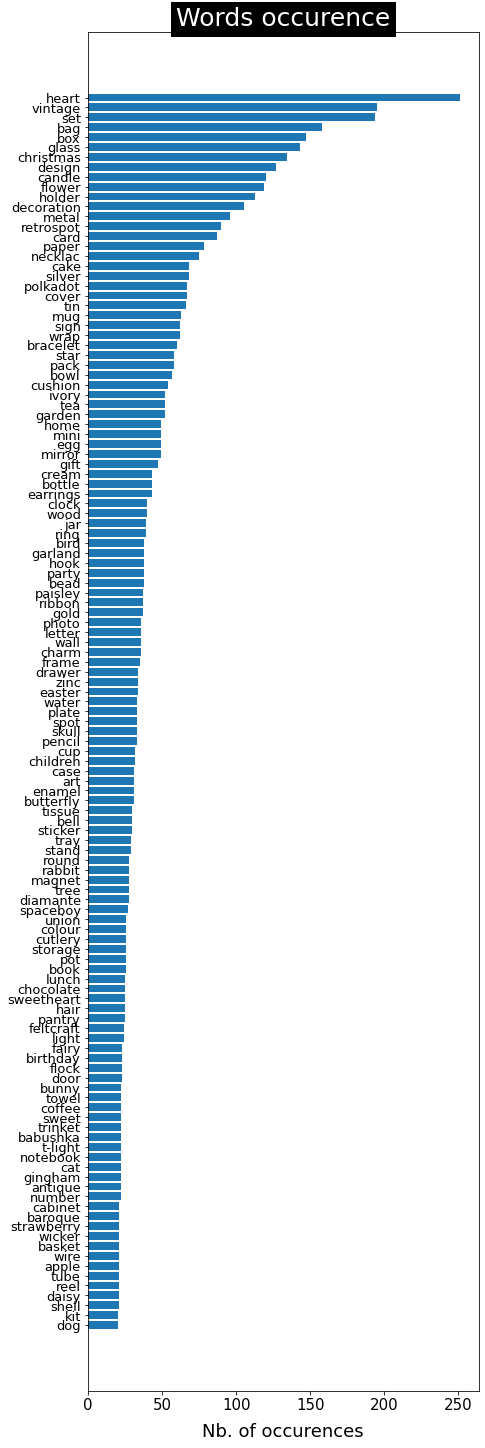

In [ ]:
from featurologists.data.load_split import load_csv

df = load_csv('../data/02_data_clean_rows/no_live_data__cleaned.csv')
list_products = build_product_list(df)
plot_product_list_histogram(list_products)

### Compute keywords: analyse product category
Original section: 3.2 Defining product categories. Oritinal cells: 28-30

In [ ]:
# export

def build_keywords_matrix(
    df: pd.DataFrame,
    list_products: List[str],
    threshold: List[int] = (0, 1, 2, 3, 5, 10),
) -> pd.DataFrame:
    # TODO: rename: liste_produits vs list_products

    liste_produits = df['Description'].unique()
    
    X = pd.DataFrame()
    for key, occurence in list_products:
        X.loc[:, key] = list(map(lambda x: int(key.upper() in x), liste_produits))
    
    label_col = []
    for i in range(len(threshold)):
        if i == len(threshold)-1:
            col = '.>{}'.format(threshold[i])
        else:
            col = '{}<.<{}'.format(threshold[i],threshold[i+1])
        label_col.append(col)
        X.loc[:, col] = 0

    df_cleaned = df
    for i, prod in enumerate(liste_produits):
        prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
        j = 0
        while prix > threshold[j]:
            j+=1
            if j == len(threshold): break
        X.loc[i, label_col[j-1]] = 1
    
    return X

In [ ]:
# export

def display_keywords_matrix(X: pd.DataFrame, threshold: List[int]):
    print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
    for i in range(len(threshold)):
        if i == len(threshold)-1:
            col = '.>{}'.format(threshold[i])
        else:
            col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
        print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

In [ ]:
threshold = [0, 1, 2, 3, 5, 10]
df = df[:1000]
X = build_keywords_matrix(df, list_products, threshold)
display_keywords_matrix(X, threshold)
X[:5]

heart


ValueError: 